# Random Forests


In this notebook we are using random forests and other similar ensemble methodes in order to predict the state (awake, REM-sleeo, nonREM-sleep) of a mouse based on its electrical brain activity.

In [1]:
#IMPORTS PACKAGES
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [2]:
path = os.path.join(os.getcwd(), 'EEG_mouse_data.csv')
data_mice = pd.read_csv(path)

In [3]:
#CREATE X AND Y FROM DATAFRAME / NORMALIZE X / SPLIT THE DATA INTO TRAIN/TEST
X = data_mice.drop(['EEGv','state'],axis=1).to_numpy()
X = MinMaxScaler().fit_transform(X)
Y = data_mice['state'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## HYPERPARAMETERS OPTIMIZATION

Many different hyperparameters can be tuned in order to obtain a good random forest classifier. In this example, we will look specifically at the number of trees in the random forest (n_estimators), The number of features to consider at each split (max_features), the maximum depth of the tree (max_depth) and the minimum number of samples required to be at a leaf node (min_samples_leaf). 

### Randomized Search

As a first optimization step, we will perform a RandomizedSearchCV on the training set. This process randomly samples different combinations of hyperparameters within specified ranges and evaluates their performance using cross-validation. It gives us a general idea of which hyperparameter ranges are promising. This process can take a lot of time if we want to explore enough sets of hyperparameters. Therefore, it is strongly advised that you **do not re-run the code for the part on randomized search**. Looking at the figures should be enough to answer the questions.

In [ ]:
##### This cell is not meant to be executed####

#RANDOMLY CHOSE SET OF HYPERPARAMETERS TO DETERMINE RANGE OF INTEREST
n_iter=1000
# Define parameter distributions
param_dist = {
    'n_estimators': list(range(1, 211, 10)),
    'max_features': randint(5,20),
    'max_depth': list(range(1, 50, 2)),  
    'min_samples_leaf': randint(1, 25)  
}
# Create a random forest classifier
clf = RandomForestClassifier(random_state=0, class_weight='balanced')

# Create randomized search object
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist, n_iter=n_iter, cv=4, scoring='balanced_accuracy', verbose=0, n_jobs = -1, random_state=0)

# Fit randomized search to training data
random_search = random_search.fit(X_train, Y_train)


# Get best estimator
best_clf = random_search.best_estimator_

# Get results
results = random_search.cv_results_

In [7]:
# Print best parameters
print('Best parameters:', random_search.best_params_)

Best parameters: {'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 11, 'n_estimators': 71}


#### Plot Validation Scores
The following plots show how the validation scores (balanced_accuracy) change according to each individual hyperparameter.


Q2.1: For each of the hyperparameter: Is there a range of value giving particularly good results? Or particularly bad results?

Q2.2: These representations give valuable information about hyperparameters. It is nevertheless insufficient. What are/is the main problem(s) with those graphs in your opinion?

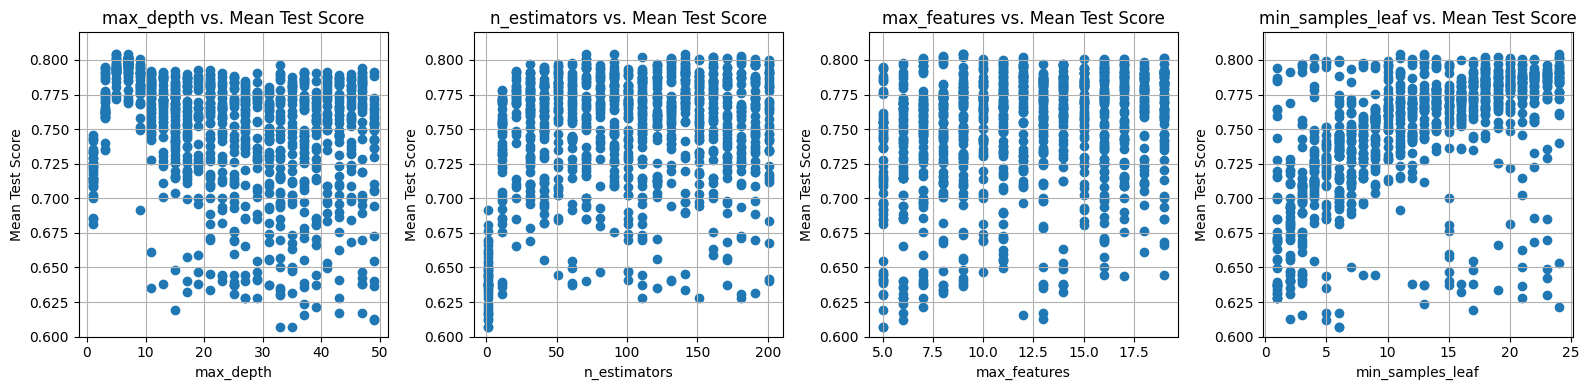

In [10]:
##### This cell is not meant to be executed####
hyperparameters_to_plot = ['param_max_depth', 'param_n_estimators', 'param_max_features', 'param_min_samples_leaf']
hyperparameter_labels = ['max_depth', 'n_estimators', 'max_features', 'min_samples_leaf']


fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for i, hyperparam in enumerate(hyperparameters_to_plot):
    axes[i].scatter(results[hyperparam], results['mean_test_score'], marker='o')
    axes[i].set_xlabel(hyperparameter_labels[i])
    axes[i].set_ylabel('Mean Test Score')
    axes[i].set_title(f'{hyperparameter_labels[i]} vs. Mean Test Score')
    axes[i].grid(True)
    axes[i].set_ylim(0.6, 0.82)

plt.tight_layout()
plt.show()

#### Heatmaps
Q2.3: What do the following plots represent? 
It's the mean test score (mean of number of good value predict) depend of the value and hyperparameter type. 

Q2.4: What do the white spots (=empty spots) in the heatmaps mean?
The result fewer than the representation on the array.
Q2.5: How do those plots address the limitation of the previous visualizations? 
For the most visualisable values 


/home/benoit.hohl/miniconda3/envs/o2score/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/benoit.hohl/miniconda3/envs/o2score/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


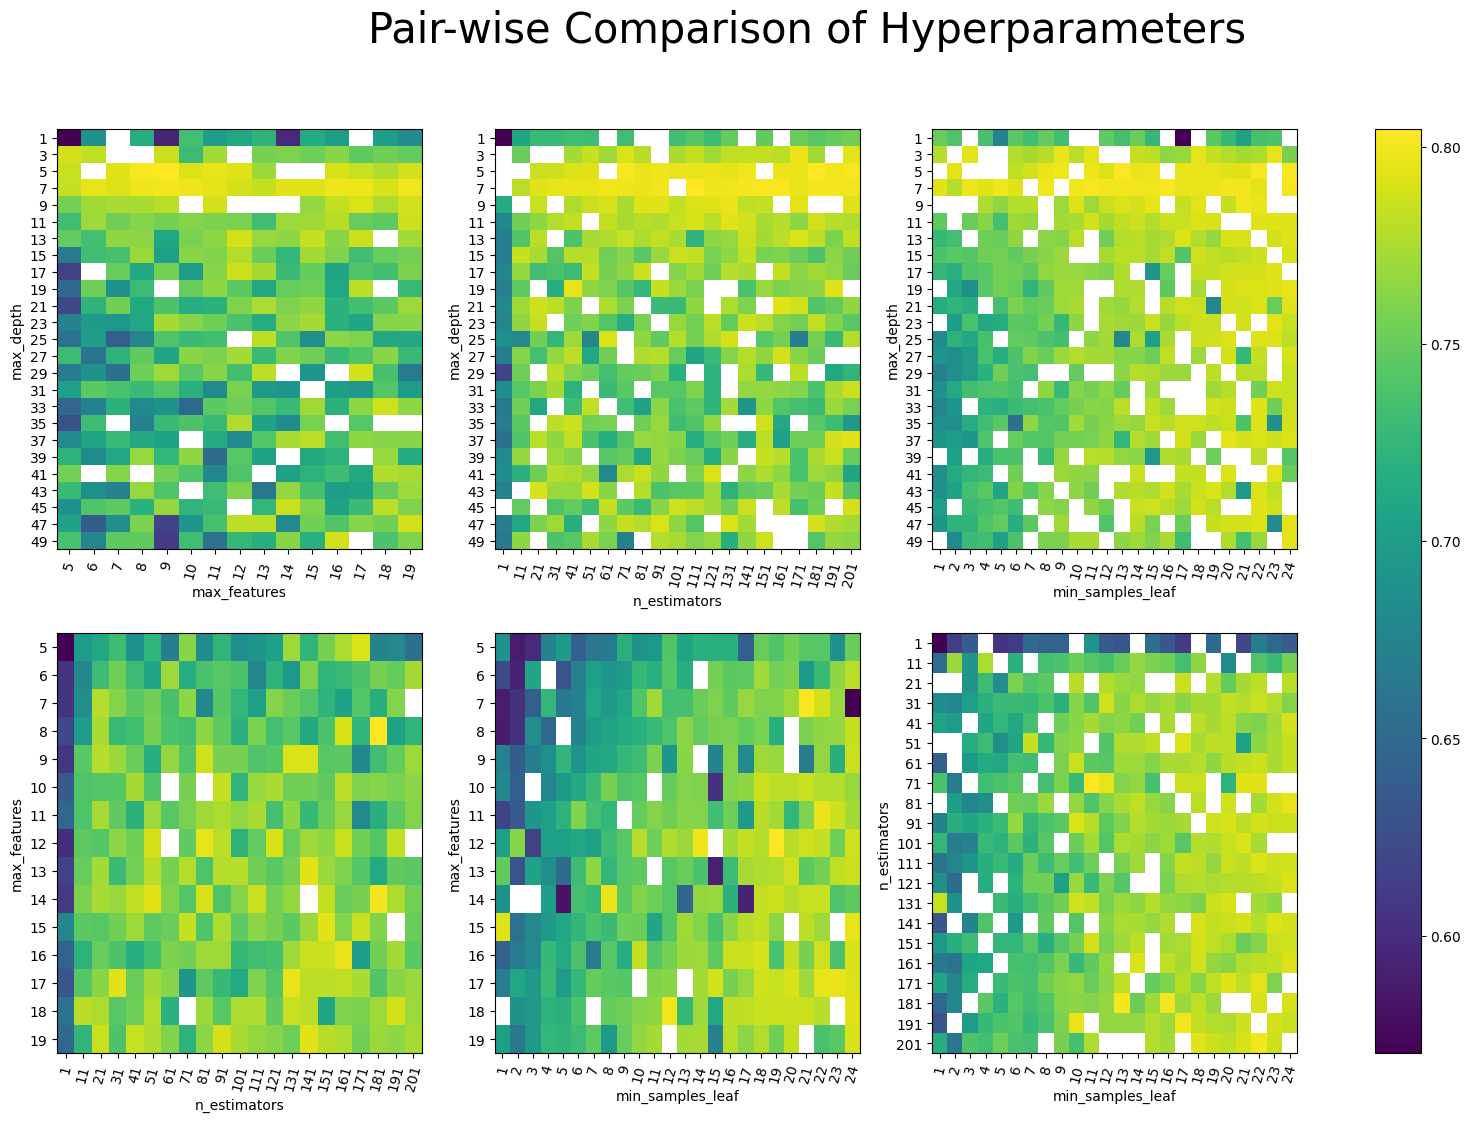

In [11]:
##### This cell is not meant to be executed####
# Convert masked arrays to regular arrays
max_depth_values = results['param_max_depth'].data
n_estimators_values = results['param_n_estimators'].data
max_features_values = results['param_max_features']
min_samples_leaf_values = results['param_min_samples_leaf']

hyperparameters = [max_depth_values,  max_features_values,n_estimators_values, min_samples_leaf_values]
hyperparameter_labels = ['max_depth', 'max_features','n_estimators', 'min_samples_leaf']

num_hyperparameters = len(hyperparameters)

# Calculate the number of rows required based on the number of hyperparameters and three columns
num_rows = (num_hyperparameters + 2) // 3  # Use integer division

fig, axes = plt.subplots(num_rows, 3, figsize=(20, 12))
fig.suptitle('Pair-wise Comparison of Hyperparameters',fontsize=30)

subplot_index = 0  # Initialize the subplot index

for i in range(num_hyperparameters):
    for j in range(i + 1, num_hyperparameters):  # Iterate over unique pairs only
        x_values = hyperparameters[i]
        y_values = hyperparameters[j]

        row_index = subplot_index // 3  # Calculate the row index based on the current subplot's position
        col_index = subplot_index % 3  # Calculate the column index based on the current subplot's position

        heatmap_data = np.zeros((len(np.unique(x_values)), len(np.unique(y_values))))

        for m, x_val in enumerate(np.unique(x_values)):
            for n, y_val in enumerate(np.unique(y_values)):
                mask = (x_values == x_val) & (y_values == y_val) #identifies data points where the hyperparameters match current evaluated combination 
                mean_score = np.mean(results['mean_test_score'][mask]) # average test score for a particular combination of x_val and y_val.
                heatmap_data[m, n] = mean_score

        im = axes[row_index, col_index].imshow(heatmap_data, cmap='viridis', aspect='auto', interpolation=None)

        axes[row_index, col_index].set_xticks(np.arange(len(np.unique(y_values))))
        axes[row_index, col_index].set_yticks(np.arange(len(np.unique(x_values))))
        axes[row_index, col_index].set_xticklabels(np.unique(y_values), rotation=75)
        axes[row_index, col_index].set_yticklabels(np.unique(x_values))

        axes[row_index, col_index].set_xlabel(hyperparameter_labels[j])
        axes[row_index, col_index].set_ylabel(hyperparameter_labels[i])

        subplot_index += 1  # Increment the subplot index

plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

### Grid Search

Q2.6: What is grid search? Explain by giving real examples from this specific task.\
Grid search is used to try out different parameter/hyperparameter to choose the best one or the best combinations of parameters (if more than one).\
In example with this case, we have differents hyperparameter : 'max_depth', 'max_features','n_estimators', 'min_samples_leaf'. We should test all combinations, to find best fit of values to create model.

Q2.7: Use the plots above to narrow the range of hyperparameters you want to explore. Which values did you choose to test for each parameter? Justify your choices.\
the plots above "*Pair-wise Comparison of Hyperparameters*"show the result of mean test score depend of hyperparameter. This show us than they have more good result :
- 'max_depth': better around [3;7]
- 'min_samples_leaf': better around [21;24] (less obvious than 'max_depth')
- 'max_features' : depend most of other hyperparameters, with 'n_estimators'and 'min_samples_leaf', this is better around [15;20] (no difference with 'max_depth')
- 'n_estimators' : 181 (no difference with 'n_estimators', good result with this value and 'max_features' 
or 'min_samples_leaf')
- 'min_samples_leaf': [1,18,19] (not big stability of good value )

Exercise 2.1: Once you know which values of hyperparameters you want to explore, complete the following code to perform a grid search on those values. Remember that the more values you choose to test, the longer the computational time required.

In [4]:
#HYPERPARAMETERS FINETUNING WITH GRID SEARCH

#Define parameter grid
param_max_depth = [7]#np.linspace(3,7,dtype=int)
param_min_sample_leaf = [21,22,23,24] #np.linspace(21,24,dtype=int)
param_grid = {'max_depth':param_max_depth, 'max_features':param_min_sample_leaf,'n_estimators':[181], 'min_samples_leaf':[18]}

#GRID SEARCH TO FIND BEST PARAMETERS
# Create random forest classifier
clf = RandomForestClassifier(random_state=0,class_weight='balanced')

# Create grid search object
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=4, n_jobs = -1, scoring='balanced_accuracy',verbose=2)

# Fit grid search to training data
grid_search = grid_search.fit(X_train,Y_train)

# Print best parameters
print('Best parameters:', grid_search.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters: {'max_depth': 7, 'max_features': 23, 'min_samples_leaf': 18, 'n_estimators': 181}


### FINAL MODEL TRAINING

It is now time to train your final RF model. Choose one final value for each of the hyperparameters based on your grid search.

Q.2.8: Which value did you choose for each hyperparameter? Why?\
This values depend of the graphics of the pair-wire comparison of hyperparmeters and the results of the previous part after several test.
Exercise 2.2: Complete the code in order to choose one final value for each of the hyperparameters and train the model on the whole training set.\
With this hyperparameter, we have a score of 88%. It's good but could be better

In [16]:
#FIT A SINGLE RANDOM FOREST GIVEN A SET OF HYPERPARAMETERS
hyperparameters = {
    ###TO CHANGE###
     'max_features': 23,
     'n_estimators': 181,
     'max_depth': 7,
     'min_samples_leaf': 18
}

# Create a Random Forest classifier with the specified parameters
rf_classifier = RandomForestClassifier(**hyperparameters, random_state=0,class_weight='balanced')#

# Fit the model on the training data
rf_classifier = rf_classifier.fit(X_train, Y_train)
print('final model trained')


final model trained


In [17]:
# score in another cell to don't waist to much time
rf_classifier.score(X_train, Y_train)

0.878440083919536

### FINAL MODEL EVALUATION

Exercise: Write the code to evaluate the performance of your final model.

Q2.9: The test set should be used only at this stage, and it is theoretically important not to change the hyperparameters based on the performance on the test set. Why?\
Because this parameters depend also of training set, change parameters may not correpsond with previous dataset. It must be conciderate like biais to change on the test set. 

Q2.10: Comment your results. -> How well does the model generalize on unseen data? Is a random forest better than a single classification tree in this case? What is the main challenge of this dataset? ...

Accuracy:93.213%
F1 score:93.461%


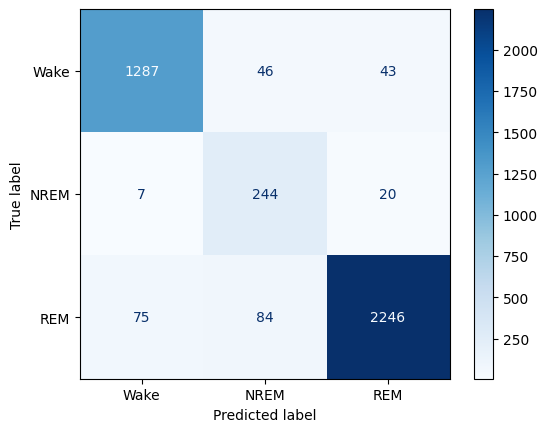

              precision    recall  f1-score   support

        Wake       0.94      0.94      0.94      1376
        NREM       0.65      0.90      0.76       271
         REM       0.97      0.93      0.95      2405

    accuracy                           0.93      4052
   macro avg       0.86      0.92      0.88      4052
weighted avg       0.94      0.93      0.93      4052

Score of model with test data are 93.213%


In [23]:
#FINAL MODEL EVALUATION
rf_classifier = rf_classifier.fit(X_test, Y_test)
# Get predictions for test data
Y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy:{accuracy*100:.3f}%')

# Calculate F1 score
f1 = f1_score(Y_test, Y_pred, average='weighted')
print(f'F1 score:{f1*100:.3f}%' )

# Calculate confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wake', 'NREM', 'REM'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

# Print classification report
print(classification_report(Y_test, Y_pred, target_names=['Wake', 'NREM', 'REM']))
# Get results
score = rf_classifier.score(X_test, Y_test)
print(f"Score of model with test data are {score*100:.3f}%")

### FEATURES IMPORTANCE

The following graph represents the importance of each feature for the classification.

Q2.11: How is this importance calculate?\
The features could have an impact on result because of resut of mesurable proprety

Q2.12: What can you conclude from this graph?\


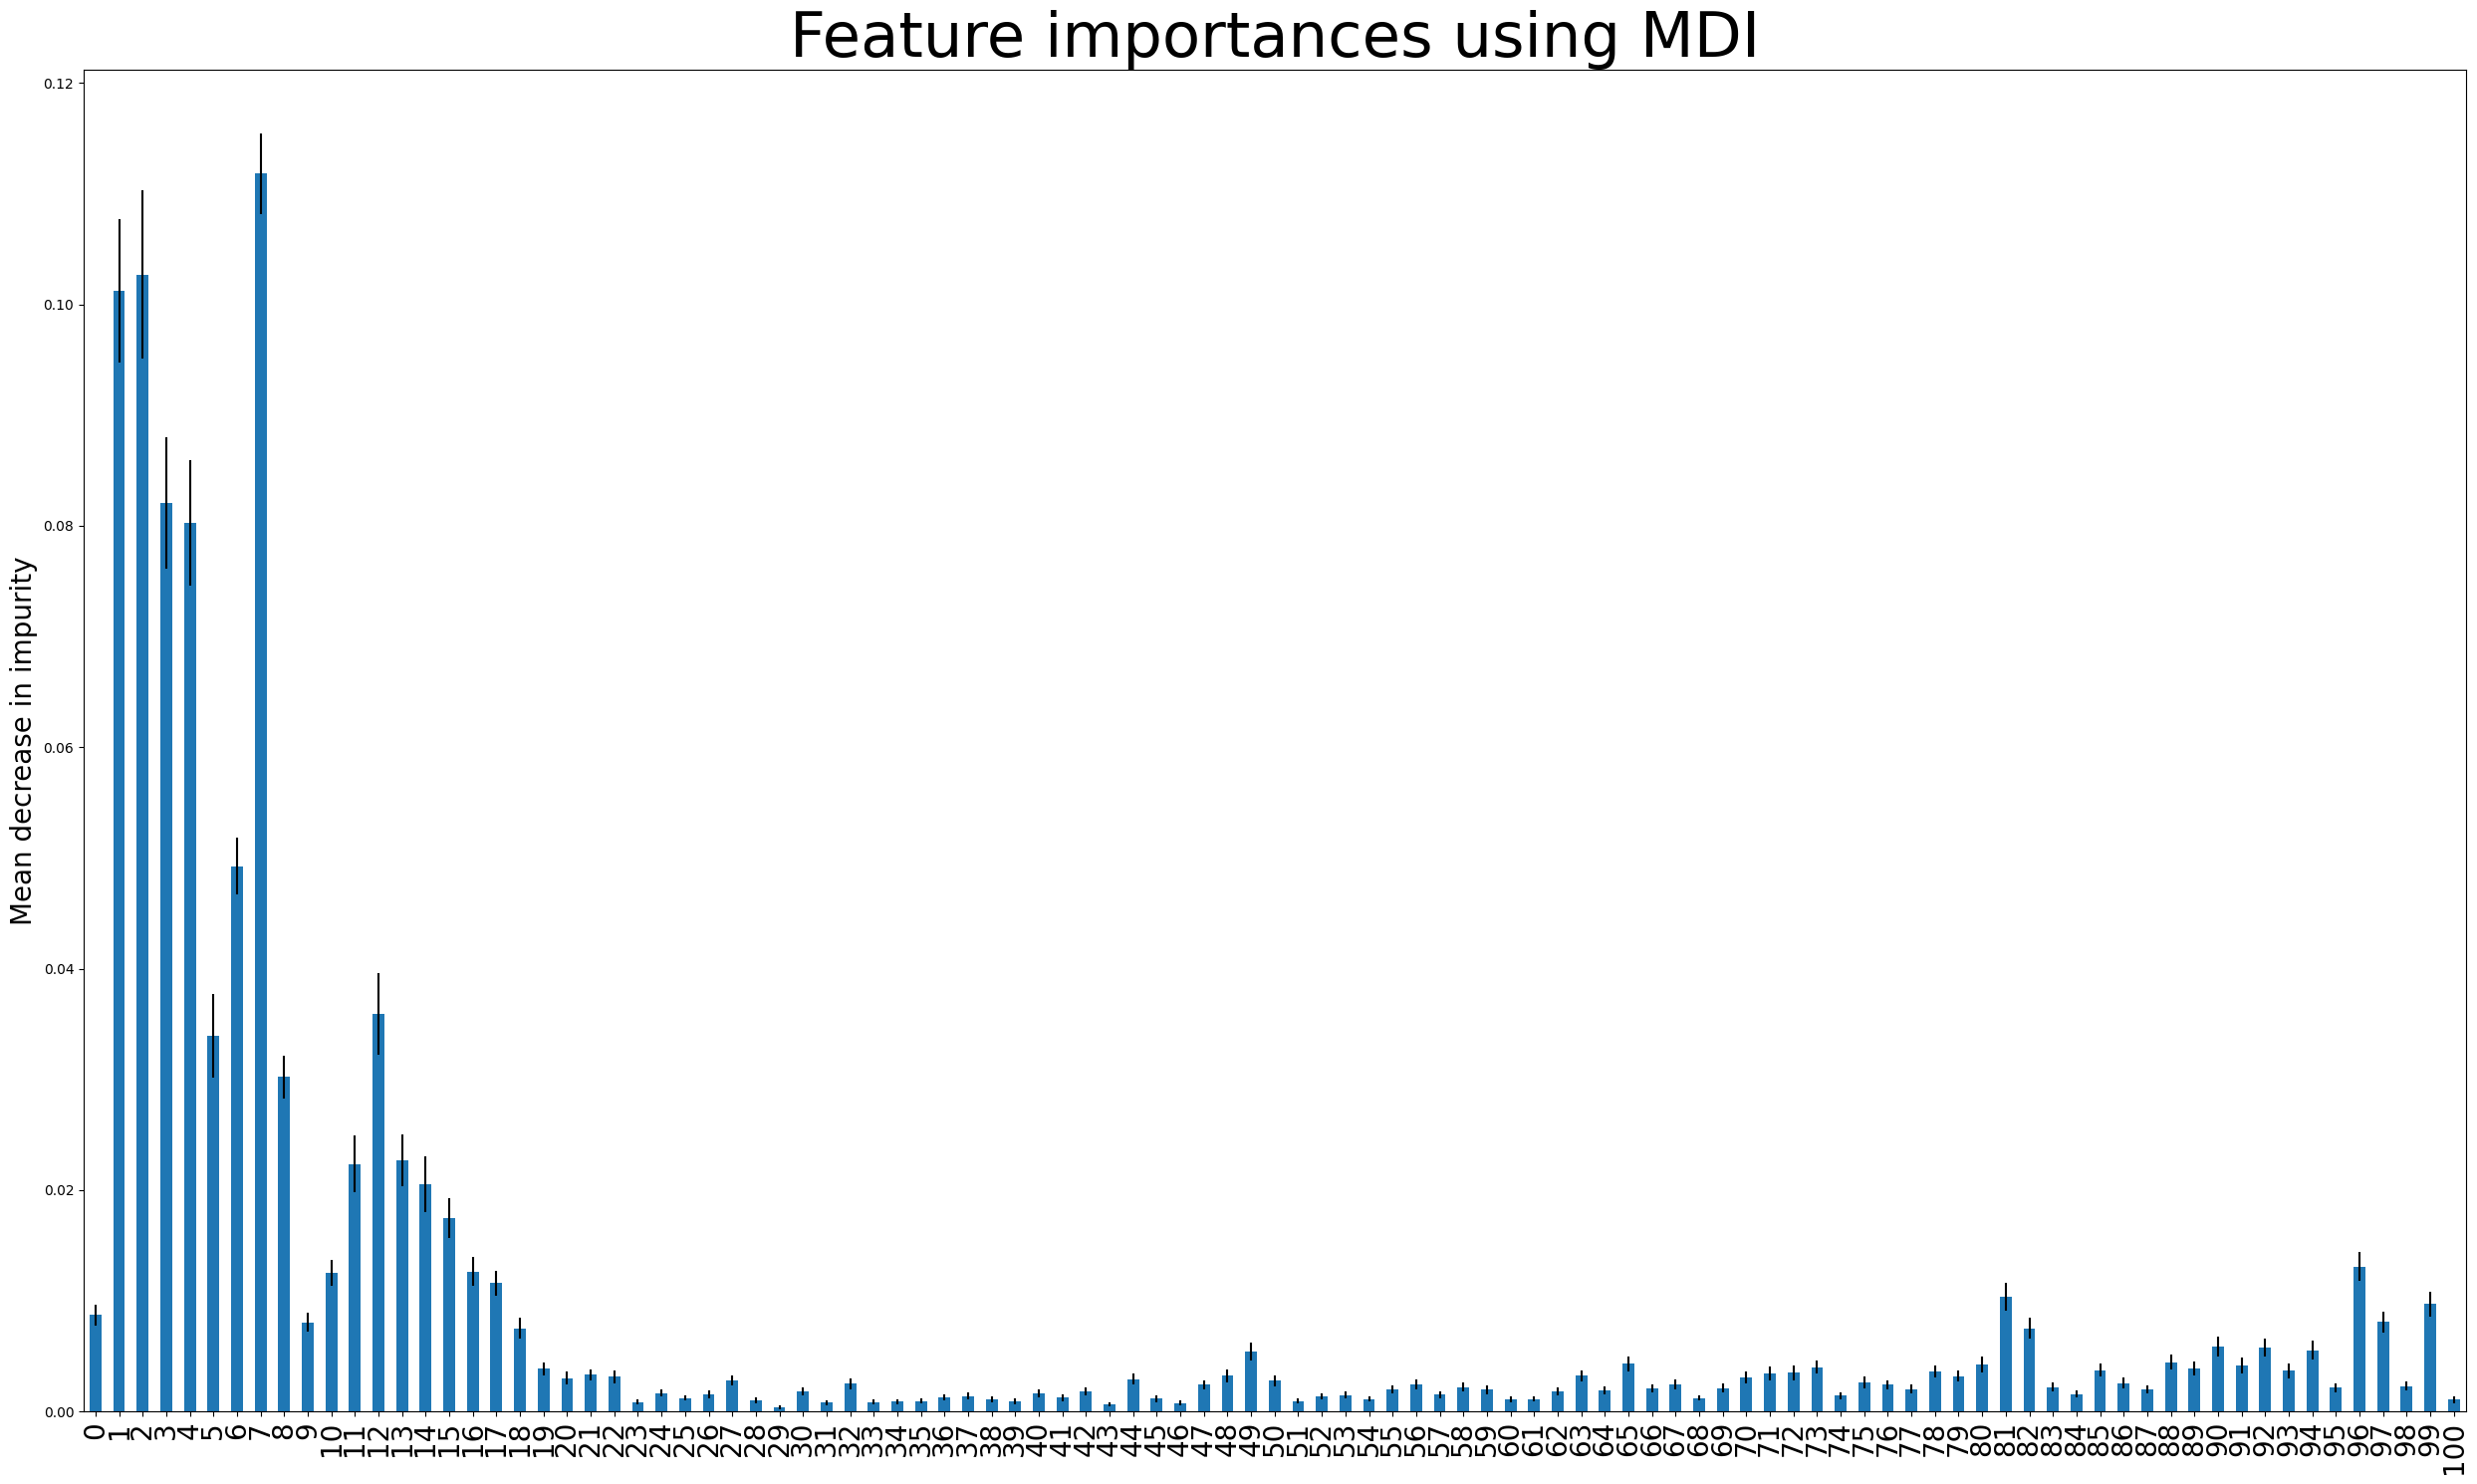

In [13]:
# Calculate feature importances and SEM
importances = rf_classifier.feature_importances_
n_trees = len(rf_classifier.estimators_)
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
sem = std / np.sqrt(n_trees)

# Plot features importance
forest_importances = pd.Series(importances)
fig, ax = plt.subplots(figsize=(25, 15))
plt.xticks(rotation=90, fontsize=20)
forest_importances.plot.bar(ax=ax, yerr=sem)  # Use SEM for error bars
ax.set_title("Feature importances using MDI", fontsize=45)
ax.set_ylabel("Mean decrease in impurity", fontsize=20)
fig.tight_layout()